# <center> MBTI Personality -- Twitter </center>
----
Data obtained from: https://www.kaggle.com/datasets/sanketrai/twitter-mbti-dataset?select=user_tweets.csv

Goals:
- Based on the reported MBTI personality on Twitter, described the mbti data
- Build a model based on user characteristics to predict their MBTI personality






In [1]:
##### Import necessary modules 

import math
import networkx as nx
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from plotly.subplots import make_subplots
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, make_scorer, roc_curve, confusion_matrix, accuracy_score, f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, PowerTransformer


In [13]:
##### Helper functions

def dataframe_summary(dataframe: pd.DataFrame,
                      max_length: int):
    
    pd.options.display.float_format = '{:,.4f}'.format

    ### Get list of column names
    col_names = dataframe.columns.to_list()

    ### Get unique count of each column
    col_length = [len(dataframe[val].unique()) for val in col_names]

    ### Append info for dataframe
    col_names.append("this_df")
    col_length.append(len(dataframe))

    ### Create new dataframe for summary
    summary_df = pd.DataFrame(list(zip(col_names, col_length)), columns=["column_name", "unique_count"])
    summary_df["uniqueness"] = summary_df["unique_count"]/len(dataframe) * 100

    ### Count nan values in each column
    nan_df = dataframe.isnull().sum(axis = 0).to_frame().reset_index().rename(columns={"index":"column_name", 0:"nan_count"})
    nan_df["nan_percent"] = nan_df["nan_count"]/len(dataframe)*100
    nan_df["percent_complete"] = 100 - nan_df["nan_percent"]

    ### Create new frame for data type in each column
    type_df = dataframe.dtypes.to_frame().reset_index().rename(columns={"index":"column_name", 0:"data_type"})
    type_df["data_type"] = type_df["data_type"].astype(str)

    ### Create new dataframe with unique entries for each column

    col_name = []
    unique_val = []
    
    for val  in dataframe.columns.to_list():

        col_name.append(val)

        if len(dataframe[val].unique())<=max_length:
            unique_val.append(list(dataframe[val].unique()))

        else:
            unique_val.append(f">{max_length} entries")

    unique_df = pd.DataFrame(list(zip(col_name, unique_val)),
                             columns=["column_name", "unique_entries"])
    
    

    ### Merge summary_df with nan_df, type_df
    summary_df = summary_df.merge(nan_df, on="column_name", how="outer")
    summary_df = summary_df.merge(type_df, on="column_name", how="outer")
    summary_df = summary_df.merge(unique_df, on="column_name", how="outer")


    return summary_df.sort_values(["data_type", "nan_count"])


def class_imbalance_treatment(df: pd.DataFrame, target_column: str):

    df_len = len(df)

    ##### count numbers of each class
    class_counter = df.groupby(target_column).count().reset_index()
    class_counter = class_counter.iloc[:,[0,1]]
    class_counter.columns = ["mbti", "class_size"]
    
    largest_class = max(class_counter["class_size"])

    
    ##### Create duplicate for each class

    temp_cols = []
    temp_multiplier = []
    temp_class_size = []

    counter = 1
    for ii in class_counter["mbti"]:

        ### multiplier calculation results in warning. The denominator should have returned an integer,
        ### but it returns single value pd.series
        class_size = class_counter.loc[class_counter["mbti"]==ii, "class_size"]
        multiplier = math.ceil(largest_class/class_size)

        temp_df = df[df[target_column]==ii]

        duplicated_df = temp_df.loc[temp_df.index.repeat(multiplier)]
        duplicated_df = duplicated_df.reset_index(drop=True)

        ##### resample again
        rng = np.random.default_rng(43)
        random_sample = rng.integers(low=0, high=len(duplicated_df), size=round(largest_class*0.8))

        resampled_df = duplicated_df.loc[random_sample, :]

        if counter==1:
            new_df = resampled_df.copy(deep=True)

        else:
            new_df = pd.concat([new_df, resampled_df], ignore_index=True)
        
        counter = counter + 1


    new_df = new_df.reset_index(drop=True)


    return new_df #resampled_df


def plot_distribution(df: pd.DataFrame):

    columns = list(df.columns)
    col_len = len(columns)

    rows_num = math.ceil(col_len/2)
    cols_num = 2

    fig = make_subplots(rows=rows_num, cols=cols_num, subplot_titles=columns,
                        horizontal_spacing=0.05, vertical_spacing=0.075)


    for ii in range(col_len):

        fig.add_trace(go.Histogram(x=df[columns[ii]]), row=math.ceil((ii+1)/2), col=2-(ii+1)%2)


    fig.update_layout(height=170*rows_num, width=1200)
    fig.show(renderer="png")

    

In [3]:
##### Load necessary data and combined them
mbti_labels = pd.read_csv("mbti_labels.csv")
user_info = pd.read_csv("user_info.csv")

user_info = user_info.merge(mbti_labels, on="id", how="inner")

users = pd.read_csv("edges.csv")
users = users.merge(mbti_labels, left_on="follower_id", right_on="id").rename(columns={"mbti_personality":"follower_mbti"})
users = users.merge(mbti_labels, left_on="followee_id", right_on="id").rename(columns={"mbti_personality":"followee_mbti"})
users = users.drop(columns=["id_x", "id_y"])


## Check out the loaded data

A few observations on the data:

1. MBTI personality: There are 16 unique values in `mbti_personality` column, and this matches with the 16 known MBTI personality type
2. Null values: Overall, most columns have zero null values except `location`, `description`, and `name` which have 1199 (14.38 %), 119 (1.43 %), and 1 (0.01%) null values, respectively
3. Location values: The value is based on what is listed on the user's profile and it may not reflect the actual location. For example, one profile has a fictional **Hateno vilage** as the location


In [4]:
user_info_summary = dataframe_summary(user_info, 13)
user_info_summary.sort_values("column_name")

,column_name,unique_count,uniqueness,nan_count,nan_percent,percent_complete,data_type,unique_entries
23,average_favorite_count,4122,49.4957,0.0000,0.0000,100.0000,float64,>13 entries
24,average_hashtag_count,1571,18.8641,0.0000,0.0000,100.0000,float64,>13 entries
27,average_media_count,1318,15.8261,0.0000,0.0000,100.0000,float64,>13 entries
26,average_mentions_count,2265,27.1974,0.0000,0.0000,100.0000,float64,>13 entries
22,average_retweet_count,8040,96.5418,0.0000,0.0000,100.0000,float64,>13 entries
21,average_tweet_length,5594,67.1710,0.0000,0.0000,100.0000,float64,>13 entries
25,average_url_count,1502,18.0355,0.0000,0.0000,100.0000,float64,>13 entries
5,description,8173,98.1388,119.0000,1.4289,98.5711,object,>13 entries
10,favourites_count,6510,78.1700,0.0000,0.0000,100.0000,int64,>13 entries
7,followers_count,3480,41.7867,0.0000,0.0000,100.0000,int64,>13 entries


## Data Imbalance

The MBTI divides individuals into 16 unique personality types. The gathered data reveals differing user counts for each type, with INFJ being the most common, represented by 917 users, and ESTP being the least common, with only 147 users. The histogram below illustrates the data's imbalance, showcasing certain personality types with notably more users than others.

It may be necessary to preprocess the data to address the imbalance present in the dataset prior to constructing model the model later.

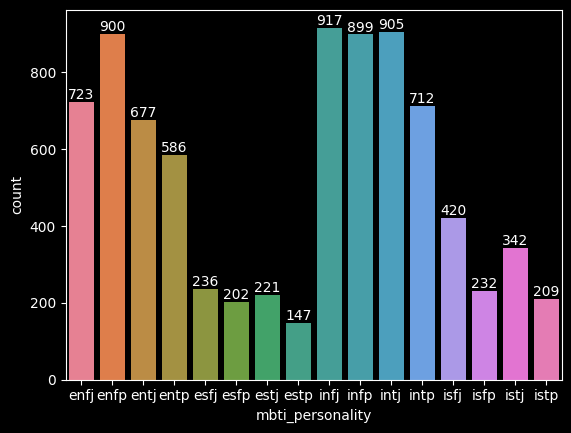

In [5]:
personality_count = user_info.groupby("mbti_personality").count().reset_index().rename(columns={"id":"count"})

ax = sns.barplot(personality_count, x="mbti_personality", y="count", hue="mbti_personality")

for i in ax.containers:
    ax.bar_label(i,)

## Data Skewness
The histograms presented below display the mean and median for specific data columns. For instance, the column `status_count` exhibits skewed data, indicated by its mean far greater than its median.

Data preprocessing might need to be performed in order to address the data skewness prior to model construction.

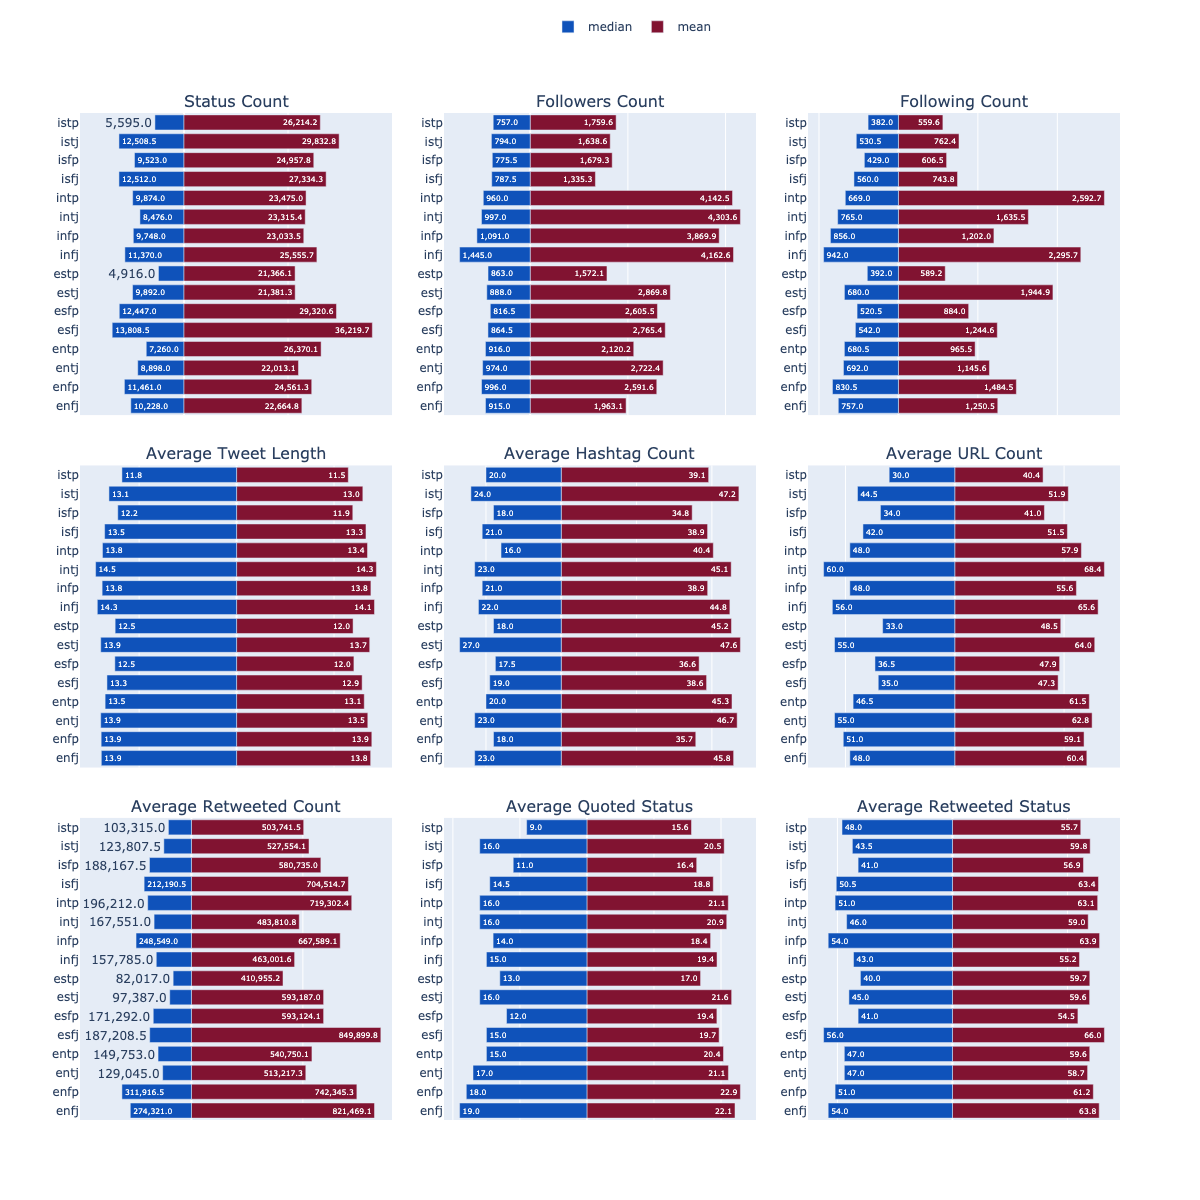

In [6]:
mbti_mean = user_info.groupby("mbti_personality").mean(numeric_only=True).reset_index()
mbti_median = user_info.groupby("mbti_personality").median(numeric_only=True).reset_index()

fig_1 = make_subplots(rows=3, cols=3, horizontal_spacing=0.05, vertical_spacing=0.05,
                      subplot_titles=("Status Count", "Followers Count", "Following Count",
                                      "Average Tweet Length", "Average Hashtag Count", "Average URL Count",
                                      "Average Retweeted Count", "Average Quoted Status", "Average Retweeted Status"))


fig_1.add_trace( go.Bar(y=mbti_median["mbti_personality"], x=-1*mbti_median["statuses_count"], orientation="h", 
                        text=mbti_median["statuses_count"], texttemplate='%{text:,.1f}', marker_color="#0F52BA",
                        showlegend=True, legendgroup="median", name="median"), 
                 row=1, col=1)

fig_1.add_trace( go.Bar(y=mbti_mean["mbti_personality"], x=mbti_mean["statuses_count"], orientation="h",
                        text=mbti_mean["statuses_count"], texttemplate='%{x:,.1f}', marker_color="#811331",
                        showlegend=True, legendgroup="mean", name="mean"), 
                 row=1, col=1)

fig_1.add_trace( go.Bar(y=mbti_mean["mbti_personality"], x=mbti_mean["followers_count"], orientation="h",
                        text=mbti_mean["followers_count"], texttemplate='%{x:,.1f}', marker_color="#811331",
                        showlegend=False, legendgroup="mean", name="mean"), 
                 row=1, col=2)

fig_1.add_trace( go.Bar(y=mbti_median["mbti_personality"], x=-1*mbti_median["followers_count"], orientation="h", 
                        text=mbti_median["followers_count"], texttemplate='%{text:,.1f}', marker_color="#0F52BA",
                        showlegend=False, legendgroup="median", name="median"), 
                 row=1, col=2)

fig_1.add_trace( go.Bar(y=mbti_mean["mbti_personality"], x=mbti_mean["friends_count"], orientation="h",
                        text=mbti_mean["friends_count"], texttemplate='%{x:,.1f}', marker_color="#811331",
                        showlegend=False, legendgroup="mean", name="mean"), 
                 row=1, col=3)

fig_1.add_trace( go.Bar(y=mbti_median["mbti_personality"], x=-1*mbti_median["friends_count"], orientation="h", 
                        text=mbti_median["friends_count"], texttemplate='%{text:,.1f}', marker_color="#0F52BA",
                        showlegend=False, legendgroup="median", name="median"), 
                 row=1, col=3)

####

fig_1.add_trace( go.Bar(y=mbti_mean["mbti_personality"], x=mbti_mean["average_tweet_length"], orientation="h",
                        text=mbti_mean["average_tweet_length"], texttemplate='%{x:,.1f}', marker_color="#811331",
                        showlegend=False, legendgroup="mean", name="mean"), 
                 row=2, col=1)

fig_1.add_trace( go.Bar(y=mbti_median["mbti_personality"], x=-1*mbti_median["average_tweet_length"], orientation="h", 
                        text=mbti_median["average_tweet_length"], texttemplate='%{text:,.1f}', marker_color="#0F52BA",
                        showlegend=False, legendgroup="median", name="median"), 
                 row=2, col=1)

fig_1.add_trace( go.Bar(y=mbti_mean["mbti_personality"], x=mbti_mean["total_hashtag_count"], orientation="h",
                        text=mbti_mean["total_hashtag_count"], texttemplate='%{x:,.1f}', marker_color="#811331",
                        showlegend=False, legendgroup="mean", name="mean"), 
                 row=2, col=2)

fig_1.add_trace( go.Bar(y=mbti_median["mbti_personality"], x=-1*mbti_median["total_hashtag_count"], orientation="h", 
                        text=mbti_median["total_hashtag_count"], texttemplate='%{text:,.1f}', marker_color="#0F52BA",
                        showlegend=False, legendgroup="median", name="median"), 
                 row=2, col=2)

fig_1.add_trace( go.Bar(y=mbti_mean["mbti_personality"], x=mbti_mean["total_url_count"], orientation="h",
                        text=mbti_mean["total_url_count"], texttemplate='%{x:,.1f}', marker_color="#811331",
                        showlegend=False, legendgroup="mean", name="mean"), 
                 row=2, col=3)

fig_1.add_trace( go.Bar(y=mbti_median["mbti_personality"], x=-1*mbti_median["total_url_count"], orientation="h", 
                        text=mbti_median["total_url_count"], texttemplate='%{text:,.1f}', marker_color="#0F52BA",
                        showlegend=False, legendgroup="median", name="median"), 
                 row=2, col=3)

####

fig_1.add_trace( go.Bar(y=mbti_mean["mbti_personality"], x=mbti_mean["total_retweet_count"], orientation="h",
                        text=mbti_mean["total_retweet_count"], texttemplate='%{x:,.1f}', marker_color="#811331",
                        showlegend=False, legendgroup="mean", name="mean"), 
                 row=3, col=1)

fig_1.add_trace( go.Bar(y=mbti_median["mbti_personality"], x=-1*mbti_median["total_retweet_count"], orientation="h", 
                        text=mbti_median["total_retweet_count"], texttemplate='%{text:,.1f}', marker_color="#0F52BA",
                        showlegend=False, legendgroup="median", name="median"), 
                 row=3, col=1)

fig_1.add_trace( go.Bar(y=mbti_mean["mbti_personality"], x=mbti_mean["number_of_quoted_statuses"], orientation="h",
                        text=mbti_mean["number_of_quoted_statuses"], texttemplate='%{x:,.1f}', marker_color="#811331",
                        showlegend=False, legendgroup="mean", name="mean"), 
                 row=3, col=2)

fig_1.add_trace( go.Bar(y=mbti_median["mbti_personality"], x=-1*mbti_median["number_of_quoted_statuses"], orientation="h", 
                        text=mbti_median["number_of_quoted_statuses"], texttemplate='%{text:,.1f}', marker_color="#0F52BA",
                        showlegend=False, legendgroup="median", name="median"), 
                 row=3, col=2)

fig_1.add_trace( go.Bar(y=mbti_mean["mbti_personality"], x=mbti_mean["number_of_retweeted_statuses"], orientation="h",
                        text=mbti_mean["number_of_retweeted_statuses"], texttemplate='%{x:,.1f}', marker_color="#811331",
                        showlegend=False, legendgroup="mean", name="mean"), 
                 row=3, col=3)

fig_1.add_trace( go.Bar(y=mbti_median["mbti_personality"], x=-1*mbti_median["number_of_retweeted_statuses"], orientation="h", 
                        text=mbti_median["number_of_retweeted_statuses"], texttemplate='%{text:,.1f}', marker_color="#0F52BA",
                        showlegend=False, legendgroup="median", name="median"), 
                 row=3, col=3)

fig_1.update_layout(height=1200, width=1200, barmode="overlay", hovermode=False, 
                    legend=dict(yanchor="top", y=1.1, xanchor="left", x=0.45, orientation="h"),
                    xaxis1=dict(range=[-20000, 40000]), xaxis7=dict(range=[-500000, 900000]))
# fig_1.update_traces(texttemplate='%{x:.1f}')

fig_1.update_xaxes(showticklabels=False)



fig_1.show(renderer="png")

In [7]:
user_info_desc = user_info.describe().T
user_info_desc["3_std_above_mean"] = user_info_desc["mean"] + 3*user_info_desc["std"]
user_info_desc

,count,mean,std,min,25%,50%,75%,max,3_std_above_mean
id,"8,328.0000","137,293,532,334,157,232.0000","330,760,124,433,714,432.0000",295.0000,"46,680,172.2500","274,024,556.0000","2,317,029,997.0000","1,176,567,558,868,103,168.0000","1,129,573,905,635,300,480.0000"
id_str,"8,328.0000","137,293,532,334,157,232.0000","330,760,124,433,714,432.0000",295.0000,"46,680,172.2500","274,024,556.0000","2,317,029,997.0000","1,176,567,558,868,103,168.0000","1,129,573,905,635,300,480.0000"
followers_count,"8,328.0000","2,989.9759","17,842.6126",0.0000,529.0000,981.5000,"1,904.0000","951,791.0000","56,517.8135"
friends_count,"8,328.0000","1,430.4721","11,652.6663",0.0000,362.0000,710.0000,"1,313.2500","958,249.0000","36,388.4712"
listed_count,"8,328.0000",52.5079,177.3879,0.0000,7.0000,19.0000,45.0000,"5,727.0000",584.6715
favourites_count,"8,328.0000","17,900.9654","33,725.3044",0.0000,"1,275.7500","5,623.5000","19,077.5000","585,221.0000","119,076.8787"
statuses_count,"8,328.0000","24,746.9714","42,580.4627",20.0000,"3,150.7500","9,978.5000","27,740.5000","656,839.0000","152,488.3595"
number_of_quoted_statuses,"8,328.0000",20.2795,18.5203,0.0000,6.0000,16.0000,29.0000,191.0000,75.8405
number_of_retweeted_statuses,"8,328.0000",60.3678,47.9526,0.0000,22.0000,49.0000,90.0000,200.0000,204.2256
total_retweet_count,"8,328.0000","615,911.6160","1,268,946.3519",0.0000,"21,851.0000","185,580.0000","688,635.7500","30,961,514.0000","4,422,750.6716"


## Outliers
A lot of the columns have positively skewed distribution since mean is greater than median. This suggests that there are some outliers in these distributions. Any values that are greater than 3 standard deviation of the columns' mean will be treated as outliers and hence these rows will be dropped.


In [8]:
### Drop outliers

user_info_2 = user_info.copy(deep=True)

user_info_desc_ind = list(user_info_desc.index)
user_info_desc_ind = user_info_desc_ind[2:]

for val in user_info_desc_ind:

    user_info_2 = user_info_2[user_info_2[val]<=user_info_desc.loc[val, "3_std_above_mean"]]



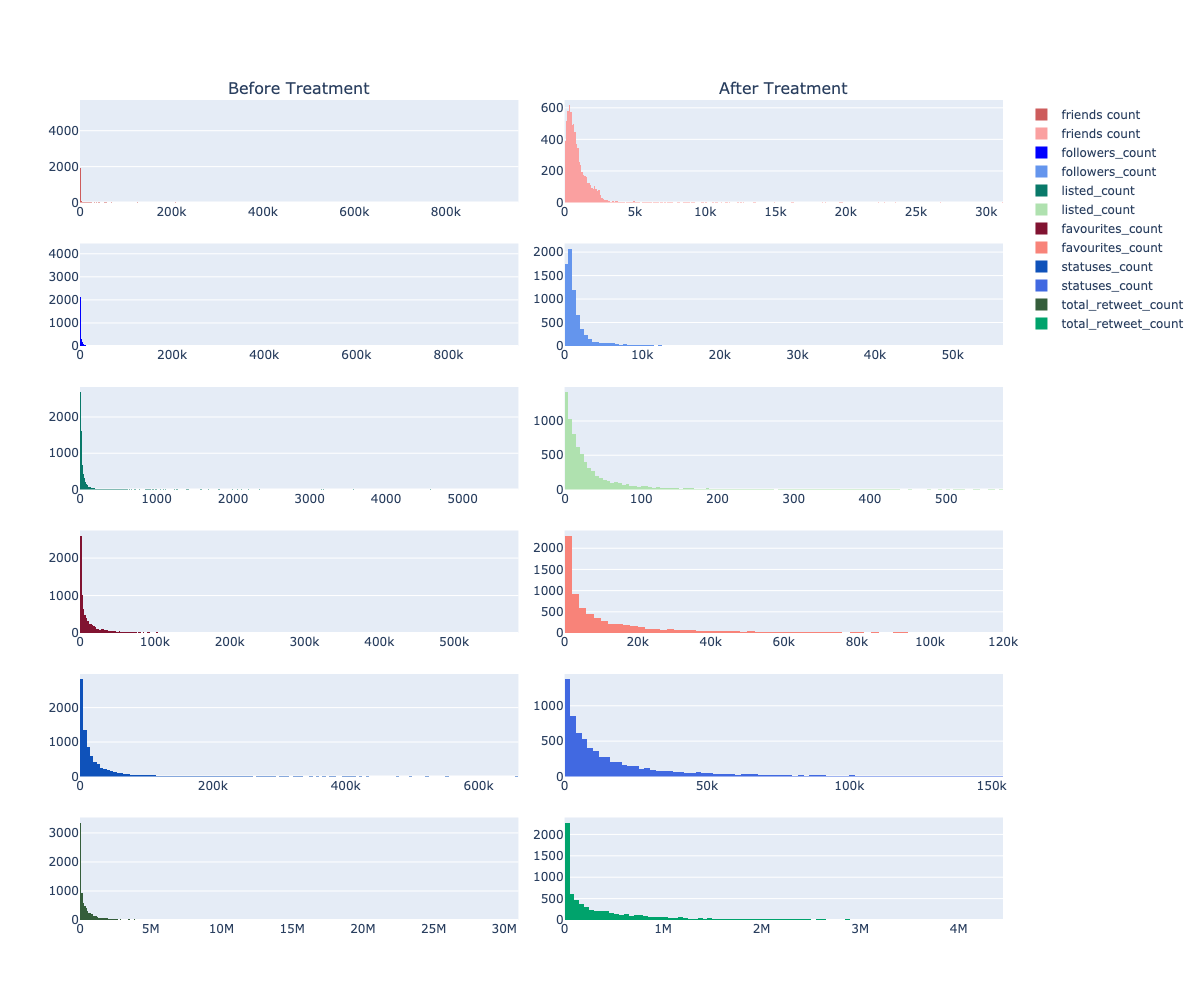

In [9]:
fig_1 = make_subplots(rows=6, cols=2, horizontal_spacing=0.05, vertical_spacing=0.05, subplot_titles=("Before Treatment", "After Treatment"))

fig_1.add_trace(go.Histogram(x=user_info["friends_count"], marker_color="#CD5C5C", name="friends count"), row=1, col=1)
fig_1.add_trace(go.Histogram(x=user_info_2["friends_count"], marker_color="#FAA0A0", name="friends count"), row=1, col=2)

fig_1.add_trace(go.Histogram(x=user_info["followers_count"], marker_color="#0000FF", name="followers_count"), row=2, col=1)
fig_1.add_trace(go.Histogram(x=user_info_2["followers_count"], marker_color="#6495ED", name="followers_count"), row=2, col=2)

fig_1.add_trace(go.Histogram(x=user_info["listed_count"], marker_color="#097969", name="listed_count"), row=3, col=1)
fig_1.add_trace(go.Histogram(x=user_info_2["listed_count"], marker_color="#AFE1AF", name="listed_count"), row=3, col=2)

fig_1.add_trace(go.Histogram(x=user_info["favourites_count"], marker_color="#811331", name="favourites_count"), row=4, col=1)
fig_1.add_trace(go.Histogram(x=user_info_2["favourites_count"], marker_color="#F88379", name="favourites_count"), row=4, col=2)

fig_1.add_trace(go.Histogram(x=user_info["statuses_count"], marker_color="#0F52BA", name="statuses_count"), row=5, col=1)
fig_1.add_trace(go.Histogram(x=user_info_2["statuses_count"], marker_color="#4169E1", name="statuses_count"), row=5, col=2)

fig_1.add_trace(go.Histogram(x=user_info["total_retweet_count"], marker_color="#355E3B", name="total_retweet_count"), row=6, col=1)
fig_1.add_trace(go.Histogram(x=user_info_2["total_retweet_count"], marker_color="#00A36C", name="total_retweet_count"), row=6, col=2)

fig_1.update_layout(height=1000, width=1200)
fig_1.show(renderer="png")

## Correlated Features

In order to mitigate multicollinearity within the model, it's advisable to eliminate correlated features. This can be achieved by calculating the correlation coefficients between features. If multiple features exhibit high correlation (approximately exceeding 0.8), only one of them will be chosen for inclusion in the model. 



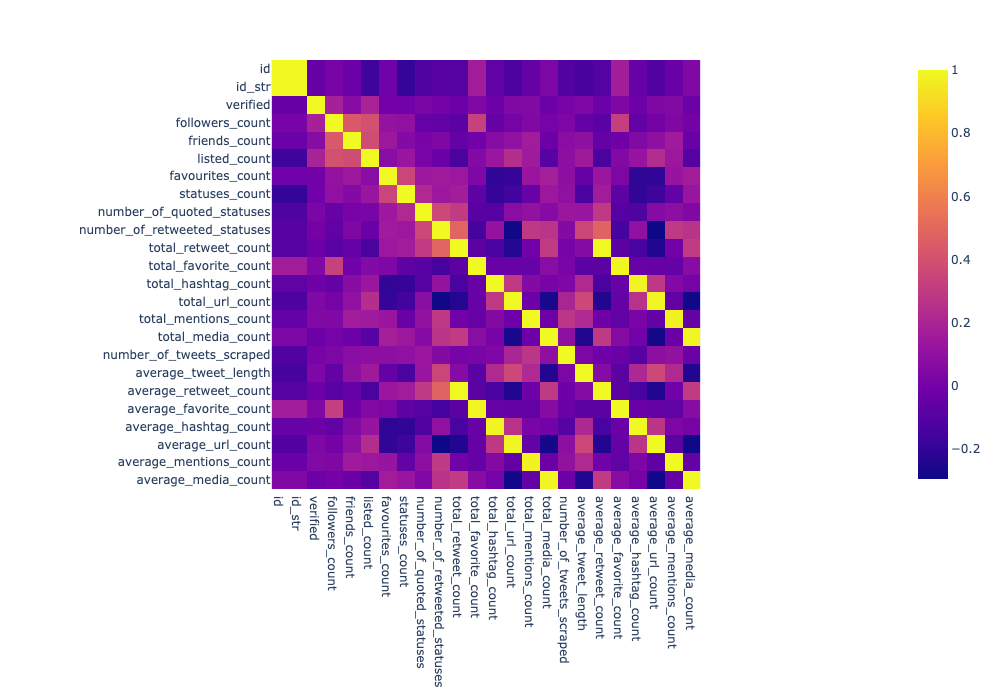

In [10]:
user_info_2_corr = user_info_2.corr(numeric_only=True)

fig_2 = px.imshow(user_info_2_corr)

fig_2.update_layout(height=700, width=1000)
fig_2.show(renderer="png")

## Feature Engineering

New features were also generated. For example `non_retweet` is the number of status that was not retweet or quoted statuses.

In [11]:
##### New columns
user_info["non_retweet"] = user_info["statuses_count"] - user_info["number_of_quoted_statuses"] - user_info["number_of_retweeted_statuses"]
user_info["average_retweet_per_status"] = user_info["total_retweet_count"]/user_info["non_retweet"]

user_info_2["non_retweet"] = user_info["statuses_count"] - user_info["number_of_quoted_statuses"] - user_info["number_of_retweeted_statuses"]
user_info_2["average_retweet_per_status"] = user_info_2["total_retweet_count"]/user_info_2["non_retweet"]



## Data Preprocessing

Data preprocessing includes:

1. Selected features <br>

    Some features were dropped and thus will not be included as part of the model building. Some of the reasons for dropping these features include:
    
    * to avoid multicolinearity: `average_media_count`
    * contain questionable data: `location`

<br>

2. Encode the target 

    Convert target (`mbti_personality`) to numbers for model building

<br>

3. Training and testing sets

    Split the original dataset into testing and traning sets. Training set was used to train the model while testing set was use to evaluate the trained model. The data was split in a way to maintain the proportion of each class.

<br>

4. Dataset rescale

    To scale the dataset, the training set was fit to the scaler. The fitted scaler was then used to transform both training and testing sets.


In [12]:

##### List of features that will be used in the model
selected_features = list(user_info_desc.index)[2:-6]
selected_features.append("non_retweet")
selected_features.append("average_retweet_per_status")
selected_features.remove("statuses_count")
selected_features.remove("number_of_tweets_scraped")
selected_features.remove("number_of_retweeted_statuses")

##### New dataframe with the selected features
selected_user_info = user_info[selected_features]

##### Encode the mbti personality to numbers
labeler = LabelEncoder()
labeler.fit(list(user_info["mbti_personality"]))
target = labeler.transform(list(user_info["mbti_personality"]))

##### Split data
train_x, test_x, train_y, test_y = train_test_split(selected_user_info, target, 
                                                    test_size=0.2, random_state=43,
                                                    stratify=target)

##### Data scaling
scaler = PowerTransformer()
scaler.fit(train_x)

train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)


## Training set data distribution after preprocessing

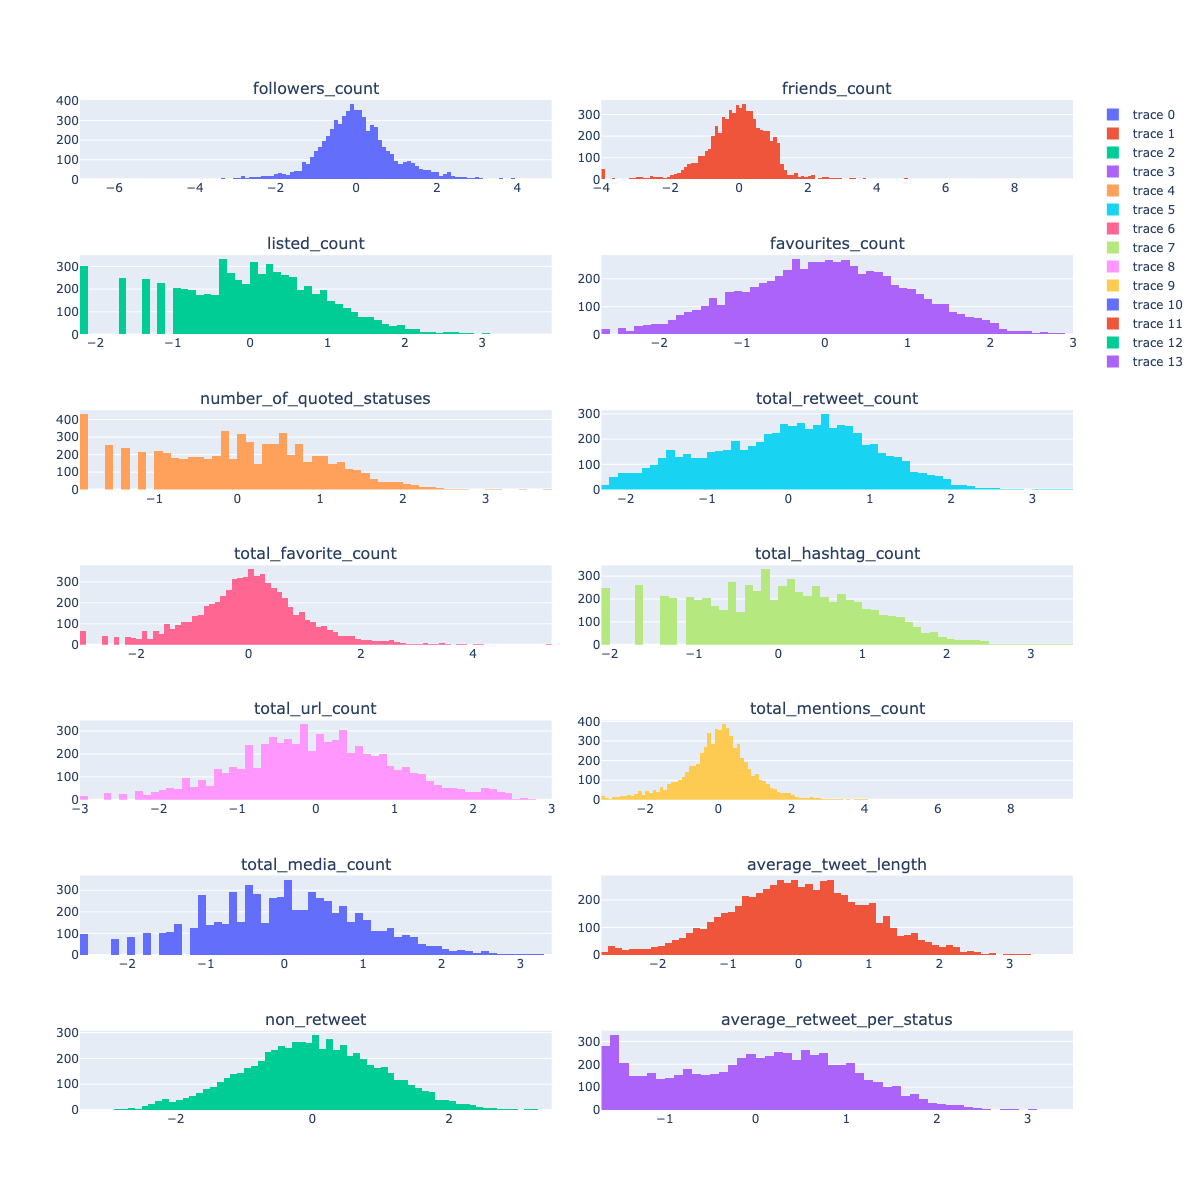

In [14]:
train_x_df = pd.DataFrame(train_x, columns=selected_features)

plot_distribution(train_x_df)

## Model Training

4 different models were constructed and tested. The models used were:

* Random forest classifier
* Histogram-based Gradient Boosting Classification Tree
* K-nearest neighbor
* Logistic regression

For each classifier, the model was first trained on the most basic settings (no specification included except random state). Then each model performance was evaluated based on accuracy score, balanced accuracy score, F1 score, and area under the curve for receiver operating characteristic (ROC) curve.

In [15]:
### Random Forest Classifier
rfc = RandomForestClassifier(random_state=43)
rfc.fit(train_x, train_y)
rfc_result = rfc.predict_proba(test_x)
rfc_result_2 = rfc.predict(test_x)
rfc_roc = roc_auc_score(test_y, rfc_result, multi_class="ovr")
rfc_acc = accuracy_score(test_y, rfc_result_2)
rfc_bal_acc = balanced_accuracy_score(test_y, rfc_result_2, adjusted=True)
rfc_f1 = f1_score(test_y, rfc_result_2, average="micro")
rfc_scores = [rfc_roc, rfc_acc, rfc_bal_acc, rfc_f1]

### Hist Gradient Boosting Classifier
hbc = HistGradientBoostingClassifier(random_state=43)
hbc.fit(train_x, train_y)
hbc_result = hbc.predict_proba(test_x)
hbc_result_2 = hbc.predict(test_x)
hbc_roc = roc_auc_score(test_y, hbc_result, multi_class="ovr")
hbc_acc = accuracy_score(test_y, hbc_result_2)
hbc_bal_acc = balanced_accuracy_score(test_y, hbc_result_2, adjusted=True)
hbc_f1 = f1_score(test_y, hbc_result_2, average="micro")
hbc_scores = [hbc_roc, hbc_acc, hbc_bal_acc, hbc_f1]

### K Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(train_x, train_y)
knn_result = knn.predict_proba(test_x)
knn_result_2 = knn.predict(test_x)
knn_roc = roc_auc_score(test_y, knn_result, multi_class="ovr")
knn_acc = accuracy_score(test_y, knn_result_2)
knn_bal_acc = balanced_accuracy_score(test_y, knn_result_2, adjusted=True)
knn_f1 = f1_score(test_y, knn_result_2, average="micro")
knn_scores = [knn_roc, knn_acc, knn_bal_acc, knn_f1]

### Logistic Regression
logreg = LogisticRegression()
logreg.fit(train_x, train_y)
logreg_result = logreg.predict_proba(test_x)
logreg_result_2 = logreg.predict(test_x)
logreg_roc = roc_auc_score(test_y, logreg_result, multi_class="ovr")
logreg_acc = accuracy_score(test_y, logreg_result_2)
logreg_bal_acc = balanced_accuracy_score(test_y, logreg_result_2, adjusted=True)
logreg_f1 = f1_score(test_y, logreg_result_2, average="micro")
logreg_scores = [logreg_roc, logreg_acc, logreg_bal_acc, logreg_f1]

#### summary
classifiers = ["rfc", "hbc", "knn", "logistic"]
metrics = ["auc_roc", "accuracy", "balanced_accuracy", "f1_score"]

classifiers_summary = pd.DataFrame(list(zip(rfc_scores, hbc_scores, knn_scores, logreg_scores)),
                                   columns=classifiers, index=metrics)
classifiers_summary





,rfc,hbc,knn,logistic
auc_roc,0.5948,0.6089,0.5366,0.6414
accuracy,0.1381,0.1465,0.1230,0.1483
balanced_accuracy,0.0363,0.0469,0.0234,0.0391
f1_score,0.1381,0.1465,0.1230,0.1483


### Model optimization
Among the 4 models trained with minimal settings, logistic regression showed to be the best. It has the best metric scores in 3 out of 4 metric scores utilized. Hence, moving forward, logistic regression will be used and optimized. 

`RandomizedSearchCV` was utilized to find the best possible setting for logistic regression.

In [16]:
### Logistic Regression
logreg = LogisticRegression(penalty="elasticnet", solver="saga", 
                            l1_ratio=0.5, max_iter=1000, multi_class="ovr", random_state=43)
logreg.fit(train_x, train_y)

logreg_dist = dict(l1_ratio = [val/10 for val in range(0,11)],
                   C = [val/10 for val in range(5,16)])

scorers = {"roc_auc": make_scorer(roc_auc_score, multi_class="ovr", response_method="predict_proba"),
           "accuracy": make_scorer(accuracy_score),
           "balanced_accuracy": make_scorer(balanced_accuracy_score, adjusted=True)}

clf = RandomizedSearchCV(logreg, logreg_dist, random_state=43, n_iter=23, verbose=3, 
                         scoring=scorers, refit="roc_auc")

clf.fit(train_x, train_y)


Fitting 5 folds for each of 23 candidates, totalling 115 fits
[CV 1/5] END C=1.2, l1_ratio=0.4; accuracy: (test=0.155) balanced_accuracy: (test=0.036) roc_auc: (test=0.651) total time=   0.5s
[CV 2/5] END C=1.2, l1_ratio=0.4; accuracy: (test=0.162) balanced_accuracy: (test=0.045) roc_auc: (test=0.654) total time=   0.6s
[CV 3/5] END C=1.2, l1_ratio=0.4; accuracy: (test=0.156) balanced_accuracy: (test=0.039) roc_auc: (test=0.641) total time=   0.6s
[CV 4/5] END C=1.2, l1_ratio=0.4; accuracy: (test=0.154) balanced_accuracy: (test=0.040) roc_auc: (test=0.644) total time=   0.6s
[CV 5/5] END C=1.2, l1_ratio=0.4; accuracy: (test=0.164) balanced_accuracy: (test=0.048) roc_auc: (test=0.648) total time=   0.6s
[CV 1/5] END C=1.2, l1_ratio=0.7; accuracy: (test=0.154) balanced_accuracy: (test=0.036) roc_auc: (test=0.652) total time=   0.6s
[CV 2/5] END C=1.2, l1_ratio=0.7; accuracy: (test=0.161) balanced_accuracy: (test=0.045) roc_auc: (test=0.654) total time=   0.5s
[CV 3/5] END C=1.2, l1_ratio

RandomizedSearchCV(estimator=LogisticRegression(l1_ratio=0.5, max_iter=1000,
                                                multi_class='ovr',
                                                penalty='elasticnet',
                                                random_state=43,
                                                solver='saga'),
                   n_iter=23,
                   param_distributions={'C': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1,
                                              1.2, 1.3, 1.4, 1.5],
                                        'l1_ratio': [0.0, 0.1, 0.2, 0.3, 0.4,
                                                     0.5, 0.6, 0.7, 0.8, 0.9,
                                                     1.0]},
                   random_state=43, refit='roc_auc',
                   scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                            'balanced_accuracy': make_scorer(balanced_accuracy_score, response_method='predict', adjusted=True),
                            'roc_auc': make_scorer(roc_auc_score, response_method='predict_proba', multi_class=ovr)},
                   verbose=3)

## Best settings
A logistic regression model performed best with the following setting: 
    * C: 0.6
    * l1_ratio: 0.9

The resulting area under the curve (auc_roc) is 0.648. 



## Confusion matrix

The performance of the model can be further investigated by constructing confusion matrix based on the actual and predicted class as illustrated below.


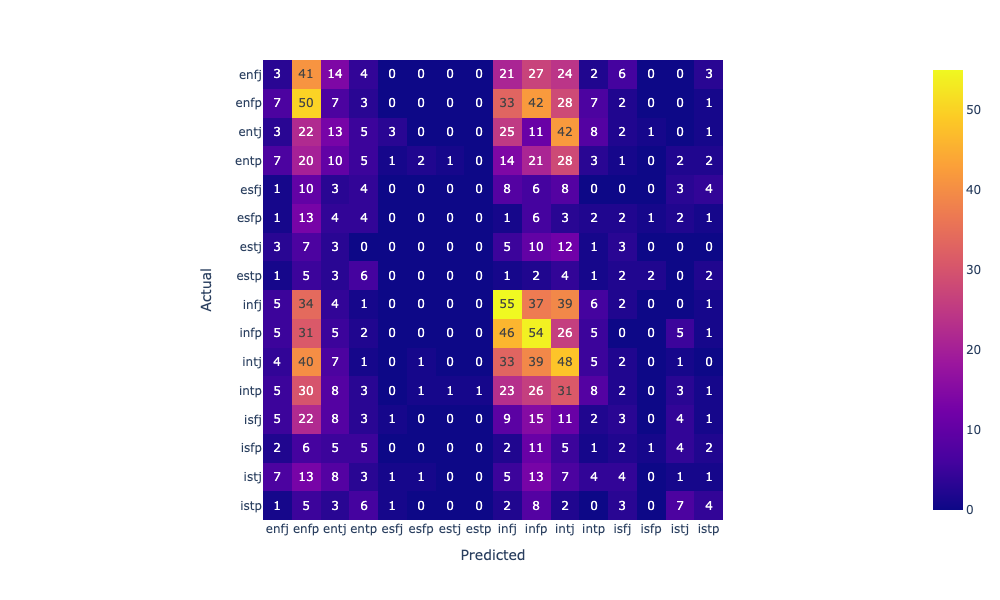

In [17]:
clf_cm = confusion_matrix(test_y, clf.predict(test_x))


mbti_list = labeler.inverse_transform([val for val in range(16)])
fig_3 = px.imshow(clf_cm, text_auto=True, labels=dict(x="Predicted", y="Actual"),
                  x=mbti_list, y=mbti_list)

fig_3.update_layout(height=600, width=1000)
fig_3.show(renderer="png")


The heatmap above shows the number of actual class versus predicted class. For example, the model correctly predicted `infj` for 55 times. However, the model has misclassified `isfj` as `infj` for 9 times. Based on this heatmap, we can clearly observed that the model is better at classifying some personality type over the other.


## AUC ROC for each class

To further investigate how the model performed with respect to each personality type, the receiver operating characteristic curves can be plotted for each class (`mbti_personality`).

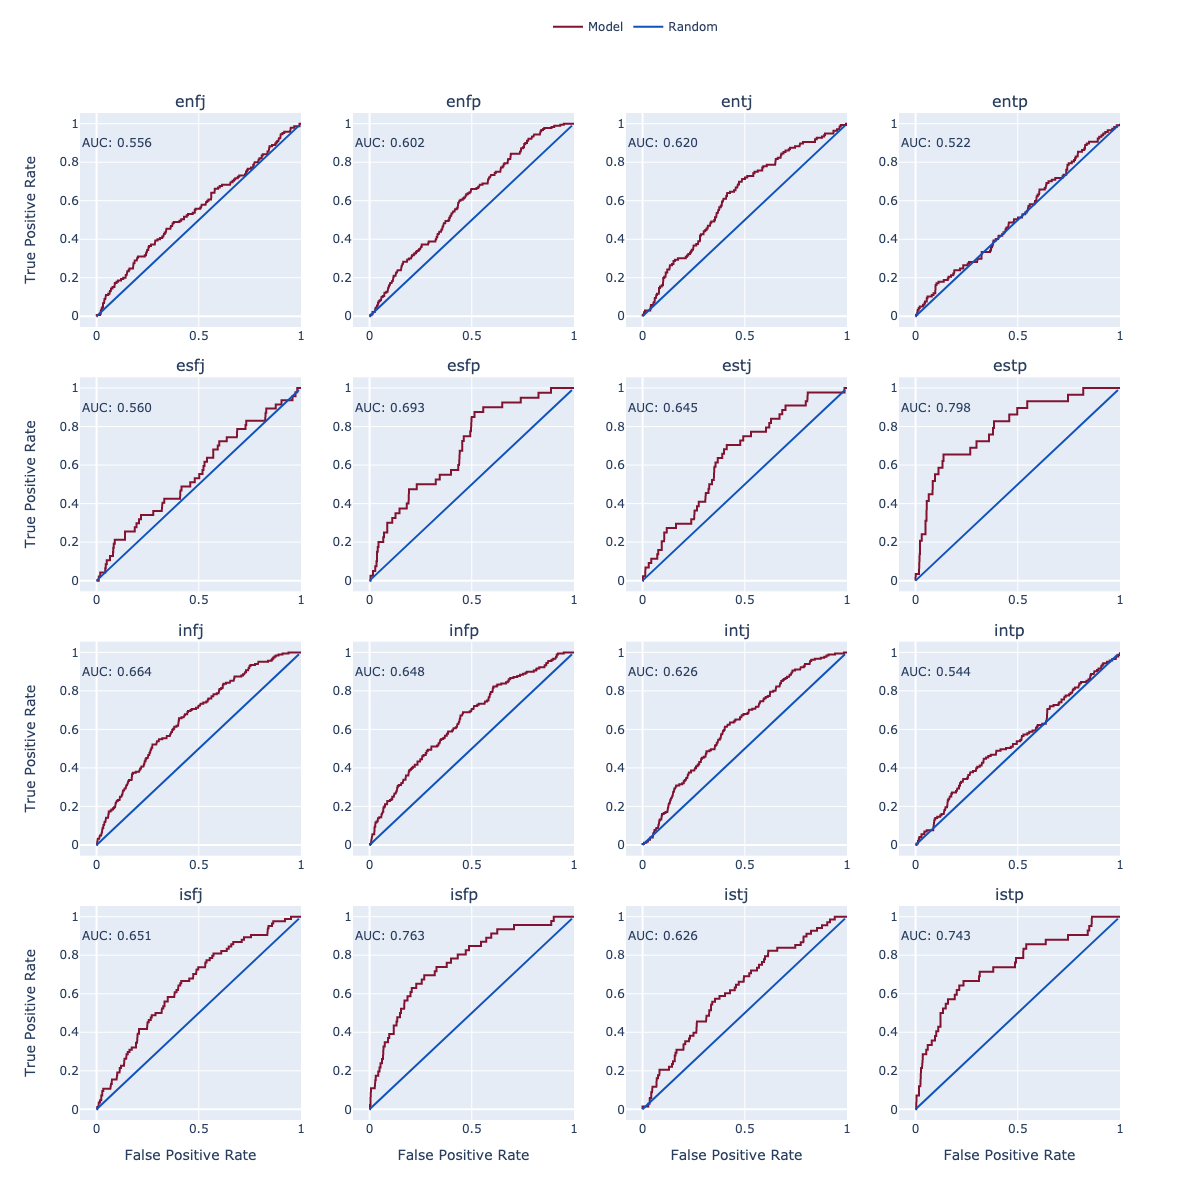

In [18]:
label_binarizer = LabelBinarizer()
binary_test_y = label_binarizer.fit_transform(test_y)

dummy_x = [val/100 for val in range(100)]

fig_4 = make_subplots(rows=4, cols=4, vertical_spacing=0.05, horizontal_spacing=0.05,
                      subplot_titles=labeler.inverse_transform([val for val in range(16)]))

for ii in range(16):

    fpr, tpr, threshold = roc_curve(binary_test_y[:,ii], logreg_result[:,ii])

    if ii==0:
        fig_4.add_trace( go.Scatter(x=fpr, y=tpr, marker_color="#811331", mode="lines",
                                    line=dict(color="#811331"),
                                    showlegend=True, legendgroup="Model", name="Model"),
                                    row=1, col=1)
        
        fig_4.add_trace( go.Scatter(x=dummy_x, y=dummy_x, marker_color="#6495ED", mode="lines",
                                    line=dict(color="#0F52BA"),
                                    showlegend=True, legendgroup="Random", name="Random"),
                                    row=1, col=1)
    
    else:

        fig_4.add_trace( go.Scatter(x=fpr, y=tpr, marker_color="#811331", mode="lines",
                                    line=dict(color="#811331"),
                                    showlegend=False, legendgroup="Model"), 
                                    row=math.ceil((ii+1)/4), col=4 if (ii+1)%4==0 else (ii+1)%4)
        fig_4.add_trace( go.Scatter(x=dummy_x, y=dummy_x, marker_color="#6495ED", mode="lines",
                                    line=dict(color="#0F52BA"),
                                    showlegend=False, legendgroup="Random"), 
                                    row=math.ceil((ii+1)/4), col=4 if (ii+1)%4==0 else (ii+1)%4)

    ##### Add area under the curve value
    auc_val = roc_auc_score([1 if val==ii else 0 for val in test_y], logreg_result[:,ii])
    fig_4.add_annotation(xref="x1", yref="y1", text=f"AUC: {auc_val:,.3f}", x=0.1, y=0.9, showarrow=False,
                         row=math.ceil((ii+1)/4), col=4 if (ii+1)%4==0 else (ii+1)%4)


fig_4.update_yaxes(title_text="True Positive Rate", col=1)
fig_4.update_xaxes(title_text="False Positive Rate", row=4)

fig_4.update_layout(height=1200, width=1200, hovermode=False, legend=dict(yanchor="top", y=1.1, xanchor="left", x=0.45, orientation="h"), )

fig_4.show(renderer="png")


# ignore this




The red lines in the above plots represent the model performance with respect to each personality type, while the blue lines represent the performance if one  randomly choses a class. Based on these plots, the model performs the worst when it had to predict `entp` class. The model output is similar to randomly choosing a class. The model built was relatively well at predicting classes such as `isfp` and `istp`.

## Conclusion

Several models were tested to classify twitter users according to mbti personality using the following features:

* followers_count
* friends_count
* listed_count
* favourites_count
* number_of_quoted_statuses
* total_retweet_count
* total_favorite_count
* total_hashtag_count
* total_url_count
* total_mentions_count
* total_media_count
* average_tweet_length
* non_retweet
* average_retweet_per_status

With minimal settings, logistic regression model showed to have the best performance. This model was further optimized to increase it performance. After optimization, the model was shown to be better at predicting some mbti personality over the others. 

